In [399]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

In [400]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [401]:
df = pd.read_csv('/content/drive/MyDrive/DATASET/VNINDEX_STOCK.csv')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["KL", "% Thay doi"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

            Ngay  Dong cua    Mo cua  Cao nhat Thap nhat
0     16/04/2024   1215.68  1,218.64  1,222.45  1,191.73
1     15/04/2024   1216.61  1,274.02  1,281.81  1,216.61
2     12/04/2024   1276.60  1,262.96  1,278.39   1,259.5
3     11/04/2024   1258.20  1,249.88  1,262.03  1,248.11
4     10/04/2024   1258.56  1,266.48  1,268.72  1,258.56
...          ...       ...       ...       ...       ...
1075  25/12/2019    960.92    958.18    962.83     957.5
1076  24/12/2019    958.88    958.88    959.43    953.29
1077  23/12/2019    959.43    959.55    960.71    956.41
1078  20/12/2019    956.41    953.55    957.52    952.26
1079  19/12/2019    952.26    950.61    955.85    946.74

[1080 rows x 5 columns]


In [402]:
#định dạng cấu trúc thời gian
df["Ngay"] = pd.to_datetime(df.Ngay,format="%d/%m/%Y")


#kích thước dữ liệu
df.shape


#dữ liệu 5 dòng đầu
df.head()


#xác định kiểu dữ liệu
df.info()


#mô tả bộ dữ liệu
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ngay       1080 non-null   datetime64[ns]
 1   Dong cua   1080 non-null   float64       
 2   Mo cua     1080 non-null   object        
 3   Cao nhat   1080 non-null   object        
 4   Thap nhat  1080 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 42.3+ KB


,Ngay,Dong cua
count,1080,1080.000000
mean,2022-02-17 04:02:40,1144.486769
min,2019-12-19 00:00:00,659.210000
25%,2021-01-14 18:00:00,1020.210000
50%,2022-02-19 12:00:00,1151.690000
75%,2023-03-20 06:00:00,1272.855000
max,2024-04-16 00:00:00,1528.570000
std,NaN,196.010121


In [403]:
df = df[df['Dong cua'] != '--']
df = df[df['Mo cua'] != '--']
df = df[df['Cao nhat'] != '--']
df = df[df['Thap nhat'] != '--']

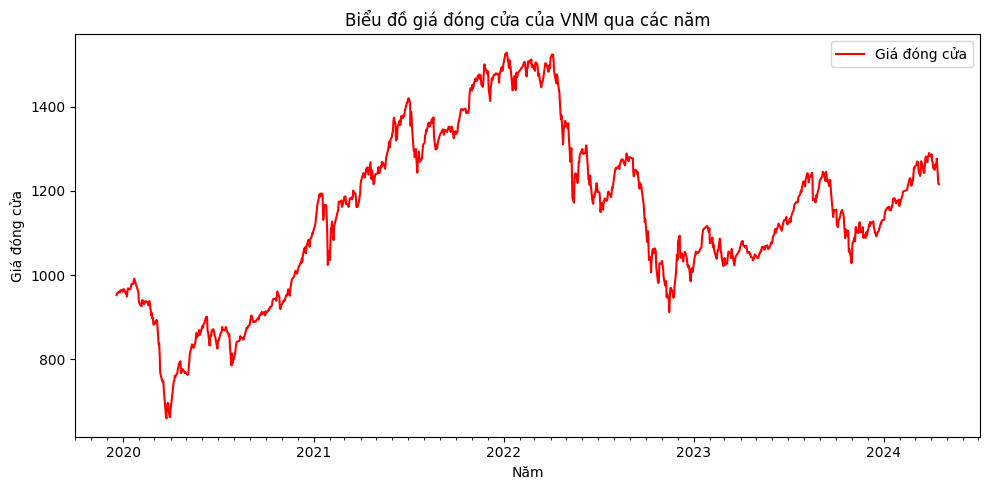

In [404]:

from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngay')

# Chuyển đổi định dạng các cột giá thành số thực
df['Dong cua'] = df['Dong cua'].astype(str).str.replace(',', '').astype(float)
df['Mo cua'] = df['Mo cua'].astype(str).str.replace(',', '').astype(float)
df['Cao nhat'] = df['Cao nhat'].astype(str).str.replace(',', '').astype(float)
df['Thap nhat'] = df['Thap nhat'].astype(str).str.replace(',', '').astype(float)

# df['Mở cửa'] = df['Mở cửa'].str.replace(',', '').astype(float)
# df['Cao nhất'] = df['Cao nhất'].str.replace(',', '').astype(float)
# df['Thấp nhất'] = df['Thấp nhất'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['Dong cua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [405]:
df1 = pd.DataFrame(df,columns=['Ngay','Dong cua'])
df1.index = df1.Ngay
df1.drop('Ngay',axis=1,inplace=True)
df1

,Dong cua
Ngay,
2019-12-19,952.26
2019-12-20,956.41
2019-12-23,959.43
2019-12-24,958.88
2019-12-25,960.92
...,...
2024-04-10,1258.56
2024-04-11,1258.20
2024-04-12,1276.60


In [406]:
data = df1.values
train_data = data[:850]
test_data = data[850:]


In [407]:
train_data

array([[ 952.26],
       [ 956.41],
       [ 959.43],
       [ 958.88],
       [ 960.92],
       [ 958.59],
       [ 963.51],
       [ 965.03],
       [ 960.99],
       [ 966.67],
       [ 965.14],
       [ 955.79],
       [ 958.88],
       [ 948.98],
       [ 960.15],
       [ 968.54],
       [ 965.84],
       [ 967.  ],
       [ 967.56],
       [ 974.31],
       [ 978.96],
       [ 978.63],
       [ 986.37],
       [ 991.46],
       [ 959.58],
       [ 936.62],
       [ 928.14],
       [ 929.09],
       [ 925.91],
       [ 938.54],
       [ 940.75],
       [ 930.73],
       [ 934.67],
       [ 937.68],
       [ 938.24],
       [ 937.45],
       [ 934.77],
       [ 927.93],
       [ 928.76],
       [ 938.13],
       [ 933.09],
       [ 903.34],
       [ 909.67],
       [ 895.97],
       [ 898.44],
       [ 882.19],
       [ 884.43],
       [ 890.61],
       [ 889.37],
       [ 893.31],
       [ 891.44],
       [ 835.49],
       [ 837.5 ],
       [ 811.35],
       [ 769.25],
       [ 7

In [408]:
data

array([[ 952.26],
       [ 956.41],
       [ 959.43],
       ...,
       [1276.6 ],
       [1216.61],
       [1215.68]])

In [409]:
len(data)

1080

In [410]:

#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [411]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [412]:
x_train

[array([0.33708705, 0.34186068, 0.3453345 , 0.34470185, 0.3470484 ,
        0.34436827, 0.35002761, 0.35177602, 0.34712892, 0.35366246,
        0.35190255, 0.34114751, 0.34470185, 0.33331416, 0.34616269,
        0.35581347, 0.35270774, 0.35404205, 0.35468621, 0.36245054,
        0.3677993 , 0.36741971, 0.37632281, 0.38217769, 0.34550704,
        0.31909681, 0.3093425 , 0.31043526, 0.3067774 , 0.32130533,
        0.32384743, 0.31232171, 0.31685378, 0.32031609, 0.32096025,
        0.32005153, 0.3169688 , 0.30910095, 0.31005567, 0.32083372,
        0.31503635, 0.28081577, 0.28809699, 0.27233827, 0.27517944,
        0.25648753, 0.25906414, 0.26617282, 0.26474648, 0.26927855]),
 array([0.34186068, 0.3453345 , 0.34470185, 0.3470484 , 0.34436827,
        0.35002761, 0.35177602, 0.34712892, 0.35366246, 0.35190255,
        0.34114751, 0.34470185, 0.33331416, 0.34616269, 0.35581347,
        0.35270774, 0.35404205, 0.35468621, 0.36245054, 0.3677993 ,
        0.36741971, 0.37632281, 0.38217769, 0.

In [413]:
y_train

[0.2671275420999355,
 0.20276985368546974,
 0.2050818993282414,
 0.1750023005429281,
 0.1265758719057697,
 0.11798334406920019,
 0.1019715652894082,
 0.09957900064415193,
 0.10174151099659512,
 0.07675761479709209,
 0.05811171436458995,
 0.008489003404803519,
 0.0,
 0.03570442624459369,
 0.04025950124229316,
 0.04238750345081421,
 0.0035083279653997934,
 0.0038189012606973938,
 0.024178706174657116,
 0.04899006165455033,
 0.08919204932364033,
 0.1006257476764516,
 0.1021556087236587,
 0.11631545044630531,
 0.11356630164718873,
 0.12259593264010293,
 0.12445937241188909,
 0.1357435354743719,
 0.1397464801693199,
 0.14998389619950303,
 0.1561608539615349,
 0.12380371767737186,
 0.12619628232262803,
 0.13193613692831496,
 0.13509938345449513,
 0.1283242845311493,
 0.12422931811907612,
 0.12641483390080055,
 0.11877703137940554,
 0.1207209901536761,
 0.14192049323640377,
 0.15796678016011767,
 0.177739946627404,
 0.19453391000276066,
 0.20257430753657857,
 0.20129750621146592,
 0.199215514

In [414]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [415]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

In [416]:
#huấn luyện mô hình
save_model = "/content/drive/MyDrive/dataset/save_model.hdf5"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.18986, saving model to /content/drive/MyDrive/dataset/save_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 - 4s - loss: 0.1899 - 4s/epoch - 238ms/step
Epoch 2/100

Epoch 2: loss improved from 0.18986 to 0.09948, saving model to /content/drive/MyDrive/dataset/save_model.hdf5
16/16 - 0s - loss: 0.0995 - 197ms/epoch - 12ms/step
Epoch 3/100

Epoch 3: loss improved from 0.09948 to 0.08207, saving model to /content/drive/MyDrive/dataset/save_model.hdf5
16/16 - 0s - loss: 0.0821 - 184ms/epoch - 12ms/step
Epoch 4/100

Epoch 4: loss improved from 0.08207 to 0.07393, saving model to /content/drive/MyDrive/dataset/save_model.hdf5
16/16 - 0s - loss: 0.0739 - 188ms/epoch - 12ms/step
Epoch 5/100

Epoch 5: loss did not improve from 0.07393
16/16 - 0s - loss: 0.0765 - 118ms/epoch - 7ms/step
Epoch 6/100

Epoch 6: loss did not improve from 0.07393
16/16 - 0s - loss: 0.0746 - 113ms/epoch - 7ms/step
Epoch 7/100

Epoch 7: loss did not improve from 0.07393
16/16 - 0s - loss: 0.0744 - 123ms/epoch - 8ms/step
Epoch 8/100

Epoch 8: loss improved from 0.07393 to 0.07087, saving model to /content/drive/MyDrive/d

In [417]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/dataset/save_model.hdf5")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

25/25 [==============================] - 1s 4ms/step


In [418]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[850:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

8/8 [==============================] - 2s 6ms/step


In [419]:
y_test

array([[1067.07],
       [1070.64],
       [1065.85],
       [1061.79],
       [1064.63],
       [1063.76],
       [1074.98],
       [1078.05],
       [1075.17],
       [1078.39],
       [1090.84],
       [1097.82],
       [1108.31],
       [1109.54],
       [1101.32],
       [1107.53],
       [1116.02],
       [1122.46],
       [1117.42],
       [1116.97],
       [1115.22],
       [1105.4 ],
       [1111.72],
       [1118.46],
       [1125.3 ],
       [1129.38],
       [1132.03],
       [1134.33],
       [1138.35],
       [1125.39],
       [1120.18],
       [1125.5 ],
       [1132.  ],
       [1134.62],
       [1126.22],
       [1138.07],
       [1149.02],
       [1151.77],
       [1154.2 ],
       [1165.42],
       [1168.4 ],
       [1173.13],
       [1174.09],
       [1172.98],
       [1172.81],
       [1185.9 ],
       [1190.72],
       [1195.9 ],
       [1200.84],
       [1197.33],
       [1207.67],
       [1222.9 ],
       [1217.56],
       [1220.43],
       [1210.95],
       [12

In [420]:
print(x_test)

[[[0.43552728]
  [0.44857136]
  [0.4563587 ]
  ...
  [0.4678154 ]
  [0.46152342]
  [0.47057606]]

 [[0.44857136]
  [0.4563587 ]
  [0.4529654 ]
  ...
  [0.46152342]
  [0.47057606]
  [0.46914972]]

 [[0.4563587 ]
  [0.4529654 ]
  [0.45273535]
  ...
  [0.47057606]
  [0.46914972]
  [0.47325619]]

 ...

 [[0.5940692 ]
  [0.59409221]
  [0.59864728]
  ...
  [0.69431536]
  [0.6894152 ]
  [0.6890011 ]]

 [[0.59409221]
  [0.59864728]
  [0.58100212]
  ...
  [0.6894152 ]
  [0.6890011 ]
  [0.7101661 ]]

 [[0.59864728]
  [0.58100212]
  [0.59102098]
  ...
  [0.6890011 ]
  [0.7101661 ]
  [0.64116131]]]


In [421]:
len(x_test)

230

In [422]:
test.shape[0]

280

In [423]:
sc_test.shape

(280, 1)

In [424]:
sc_test

array([[0.43552728],
       [0.44857136],
       [0.4563587 ],
       [0.4529654 ],
       [0.45273535],
       [0.43816141],
       [0.46353639],
       [0.44652388],
       [0.44392427],
       [0.41857228],
       [0.42930432],
       [0.43863302],
       [0.44387826],
       [0.44582221],
       [0.4521027 ],
       [0.45444925],
       [0.4567958 ],
       [0.46037315],
       [0.46635456],
       [0.48319453],
       [0.48223981],
       [0.48501196],
       [0.47356676],
       [0.47218644],
       [0.46717125],
       [0.47189887],
       [0.47188737],
       [0.46596347],
       [0.45283887],
       [0.45389712],
       [0.45528895],
       [0.44834131],
       [0.44865188],
       [0.44135916],
       [0.43957624],
       [0.43208797],
       [0.43893209],
       [0.43758627],
       [0.44850235],
       [0.43871354],
       [0.43836845],
       [0.45347152],
       [0.45385111],
       [0.45901583],
       [0.45770452],
       [0.46895417],
       [0.46758535],
       [0.467

<ipython-input-425-67e2f937e463>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-425-67e2f937e463>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


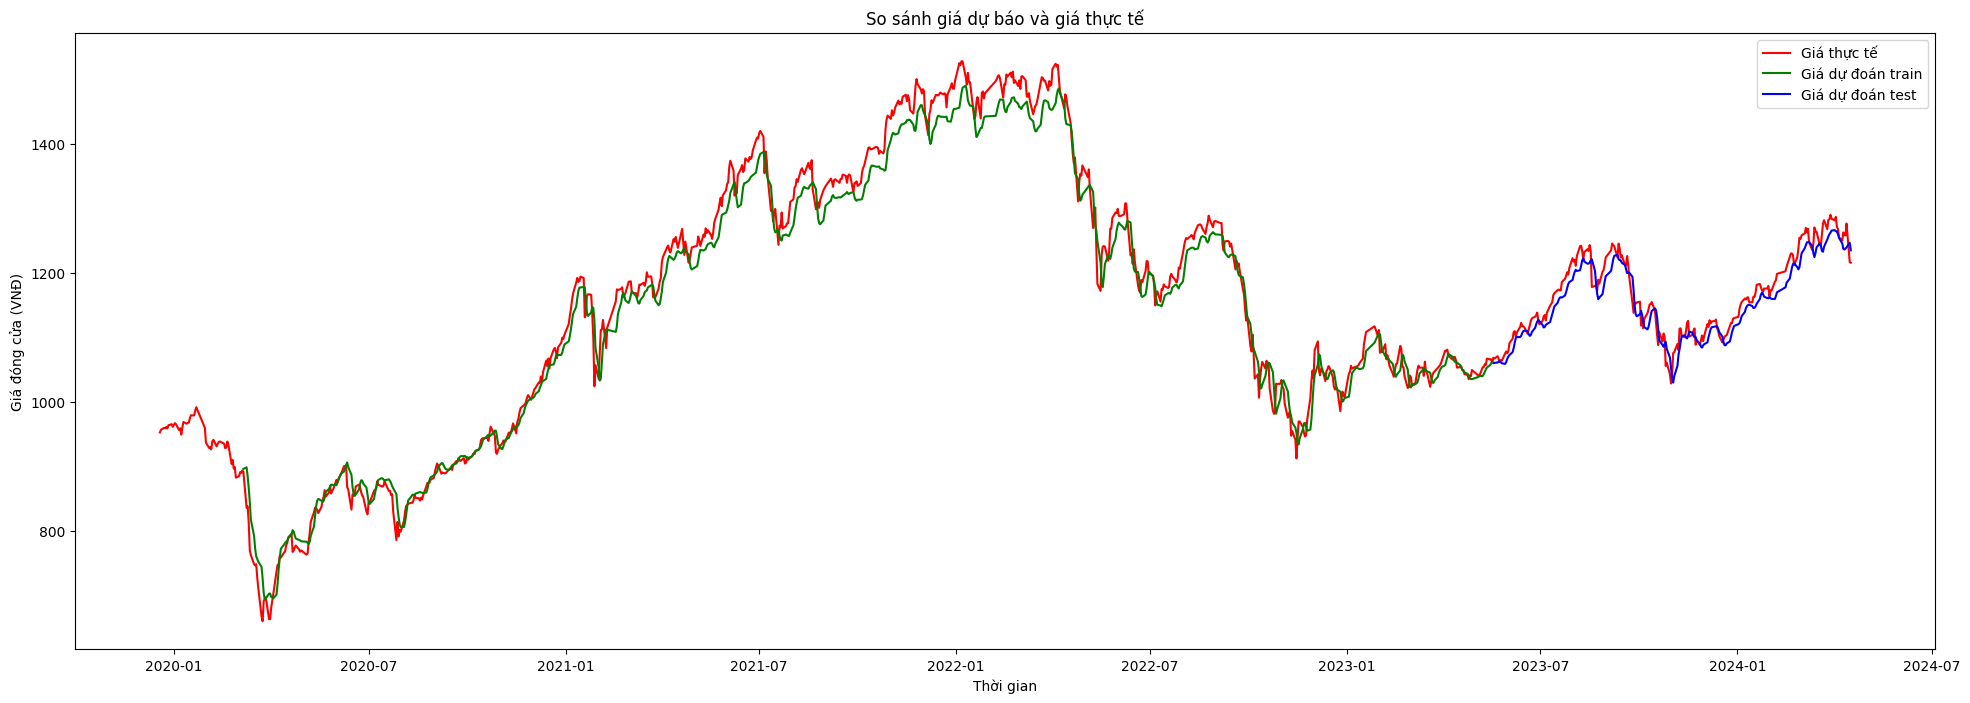

In [425]:
#lập biểu đồ so sánh
train_data1 = df1[50:850]
test_data1 = df1[850:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [426]:
len(test_data1)

230

In [427]:
test_data1.shape

(230, 2)

In [428]:
y_test_predict.shape

(230, 1)

In [429]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))


Độ phù hợp tập train: 0.9843375092184733
Sai số tuyệt đối trung bình trên tập train (VNĐ): 21.96404288330078
Phần trăm sai số tuyệt đối trung bình tập train: 0.018684401548662827


In [430]:
train_data1


,Dong cua,Dự đoán
Ngay,,
2020-03-06,891.44,895.695740
2020-03-09,835.49,898.074280
2020-03-10,837.50,884.315369
2020-03-11,811.35,866.052368
2020-03-12,769.25,844.460266
...,...,...
2023-05-12,1066.90,1053.058716
2023-05-15,1065.71,1056.944214
2023-05-16,1065.91,1059.907471


In [431]:

#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))


Độ phù hợp tập test: 0.8976481683799324
Sai số tuyệt đối trung bình trên tập test (VNĐ): 17.326461086107336
Phần trăm sai số tuyệt đối trung bình tập test: 0.014756368102191516


In [432]:
test_data1

,Dong cua,Dự đoán
Ngay,,
2023-05-19,1067.07,1060.316040
2023-05-22,1070.64,1060.792236
2023-05-23,1065.85,1062.410767
2023-05-24,1061.79,1062.715210
2023-05-25,1064.63,1061.009644
...,...,...
2024-04-10,1258.56,1236.249634
2024-04-11,1258.20,1237.643921
2024-04-12,1276.60,1239.599854


1/1 [==============================] - 0s 36ms/step


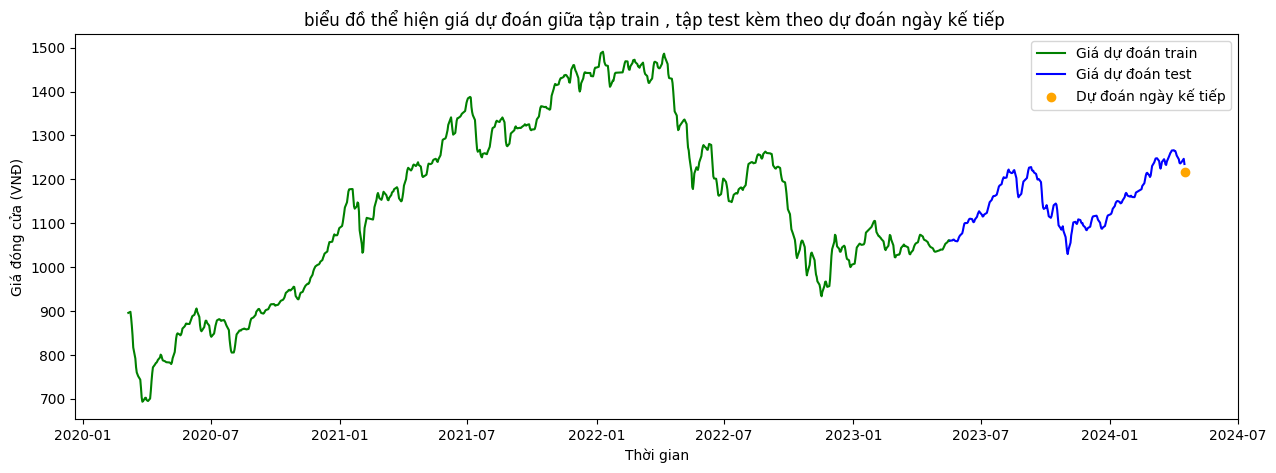

In [433]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngay'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Dong cua'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngay': [next_date], 'Đong cua': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('biểu đồ thể hiện giá dự đoán giữa tập train , tập test kèm theo dự đoán ngày kế tiếp ')
plt.legend()
plt.show()

In [434]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Dong cua'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngay': [next_date], 'Giá dự đoán mẫu': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

        Ngay  Giá dự đoán mẫu  Giá ngày trước
0 2024-04-17      1217.529785         1215.68


In [435]:
# dự đoán khoảng giá trị mà giá cổ phiếu có thể đạt được nếu áp dụng sai số
print(f'giá cổ phiếu dự đoán có thể nằm trong khoảng từ {y_next_predict[0][0]-mean_absolute_error(y_test,y_test_predict)} đến {y_next_predict[0][0]+mean_absolute_error(y_test,y_test_predict)}')

giá cổ phiếu dự đoán có thể nằm trong khoảng từ 1200.2033240701426 đến 1234.8562462423574
